In [10]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from scipy.stats import wasserstein_distance,median_abs_deviation
from scipy import stats
from tqdm.auto import tqdm
sys.path.append(os.path.abspath("../../src"))  # Adds 'src' to the module search path

In [11]:
from plot import plot_dataset_distributions,horizontal_boxplot,create_MAD_comparison_violinplot,plot_kde_grouped,plot_bar_vertical,plot_scatter,combined_plot
from read_data import apply_index_file
tqdm.pandas()

In [12]:
np.random.seed(42)
DATASET = "../../raw_data/massive.parquet"

# Distribution analysis

In [13]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [14]:
df.head()

,modified_sequence,label,filename,dataset,task
0,MQIFVK,52.767529,131023_Sunil_PPT_Brain_A_02.mzML,MSV000080692,iRT
1,FLGFFK,107.360574,131023_Sunil_PPT_Brain_A_02.mzML,MSV000080692,iRT
2,REVILNKST,96.750319,131023_Sunil_PPT_Brain_A_02.mzML,MSV000080692,iRT
3,LQGIVSWGSGCAQK,150.020844,131023_Sunil_PPT_Brain_A_02.mzML,MSV000080692,iRT
4,FPFFLR,120.160845,131023_Sunil_PPT_Brain_A_02.mzML,MSV000080692,iRT


In [15]:
print(f"length of the dataset is {len(df)}")

length of the dataset is 45856811


In [16]:
df[['filename','dataset','modified_sequence']].nunique()

filename               2892
dataset                  62
modified_sequence    964395
dtype: int64

## Dataset distributions

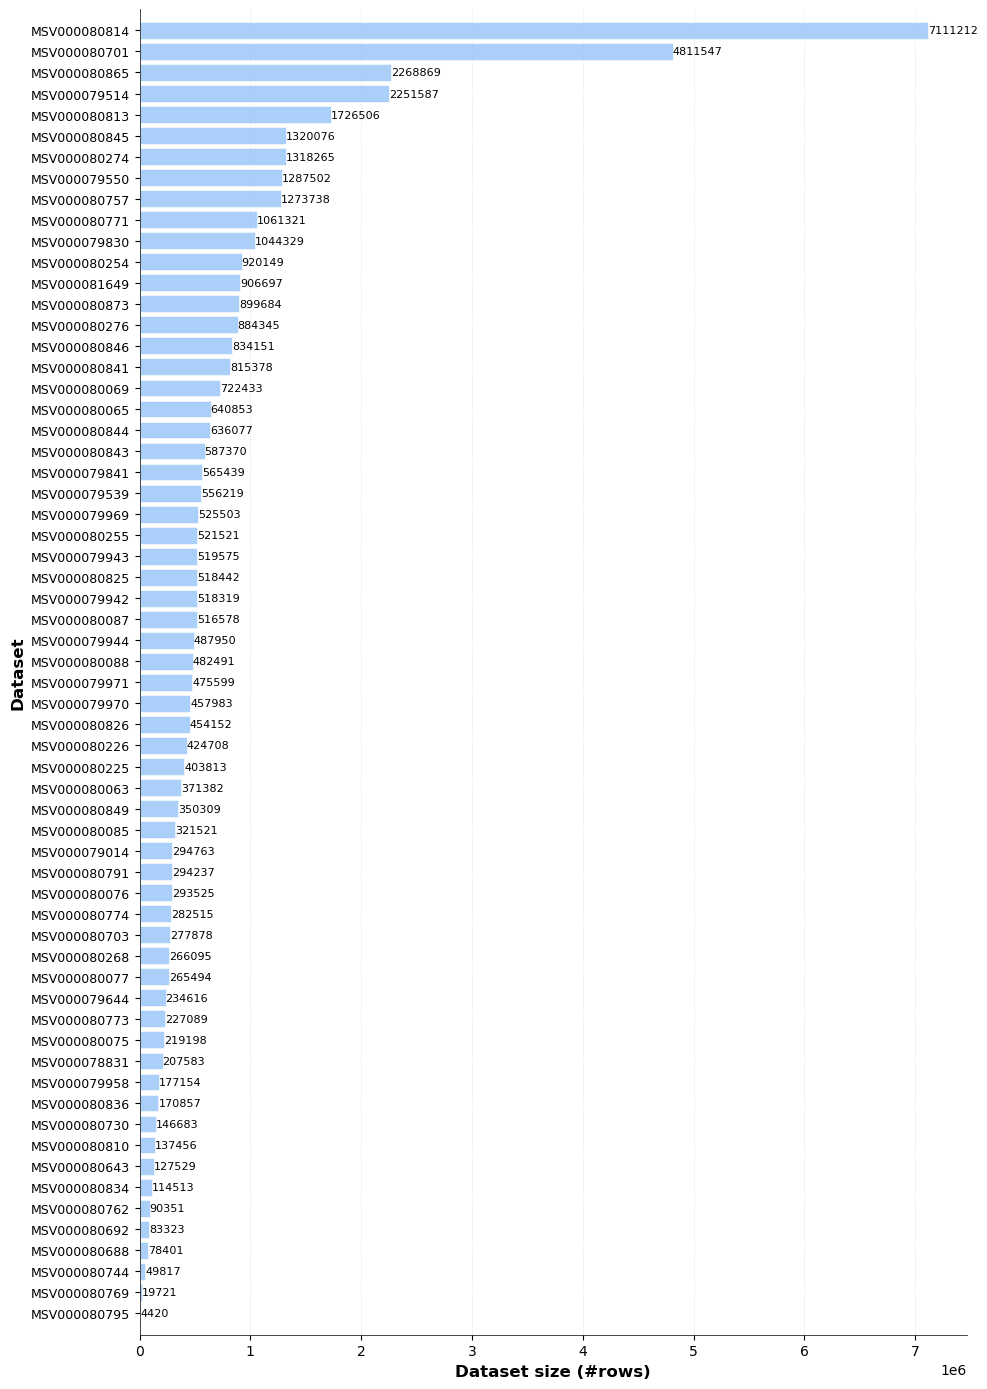

In [17]:
sequences_dataset = df.groupby('dataset')['modified_sequence'].count()
plot_dataset_distributions(sequences_dataset,'Dataset size (#rows)','Dataset')

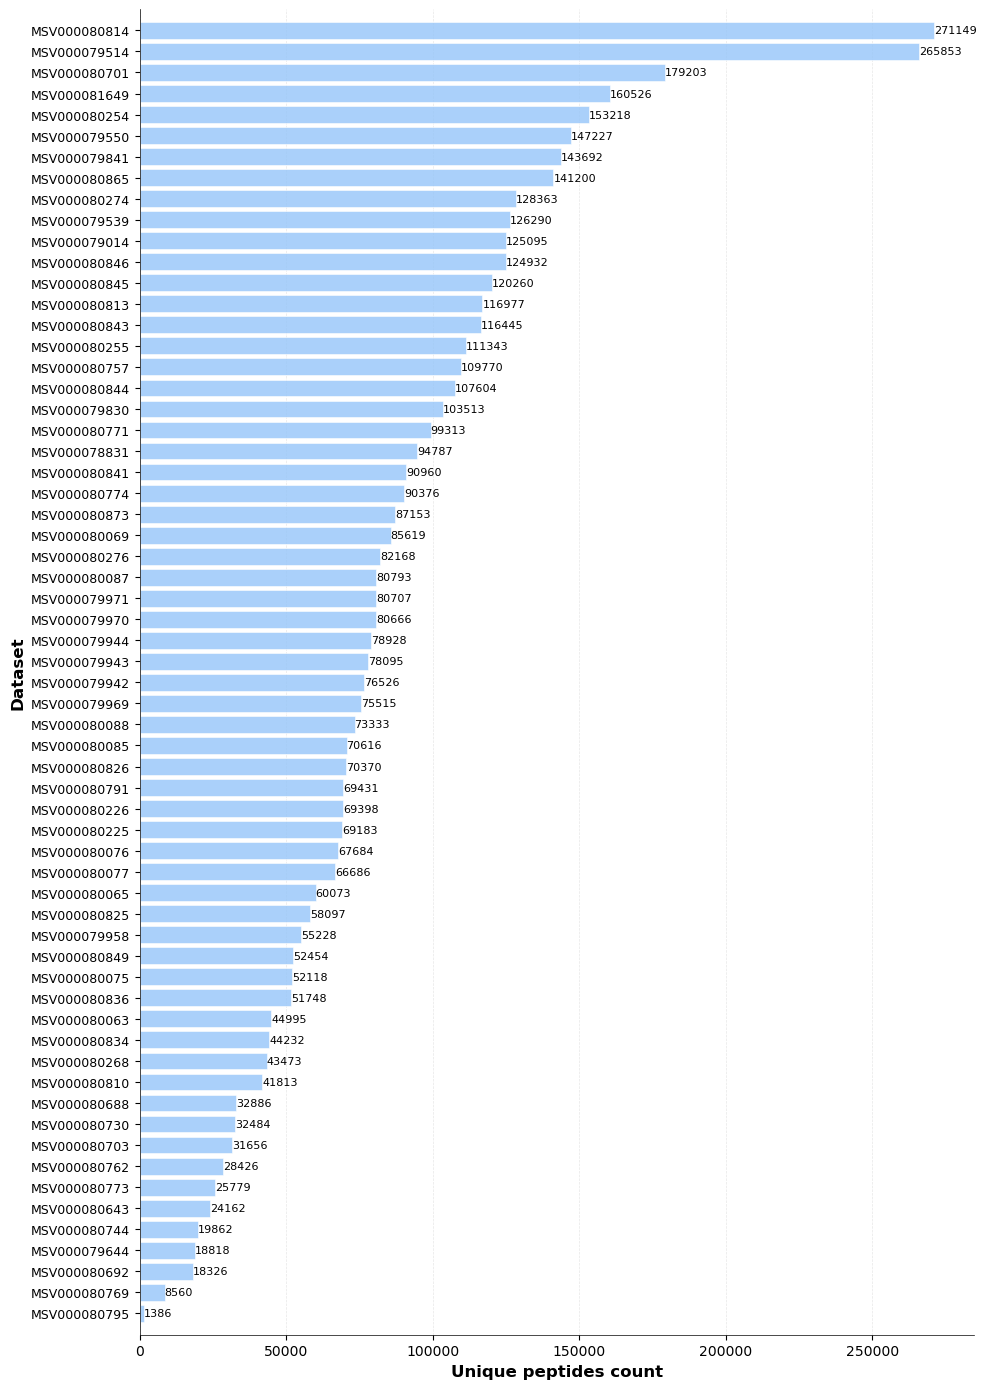

In [18]:
unique_sequences_dataset = df.groupby('dataset')['modified_sequence'].nunique()
plot_dataset_distributions(unique_sequences_dataset,'Unique peptides count','Dataset')

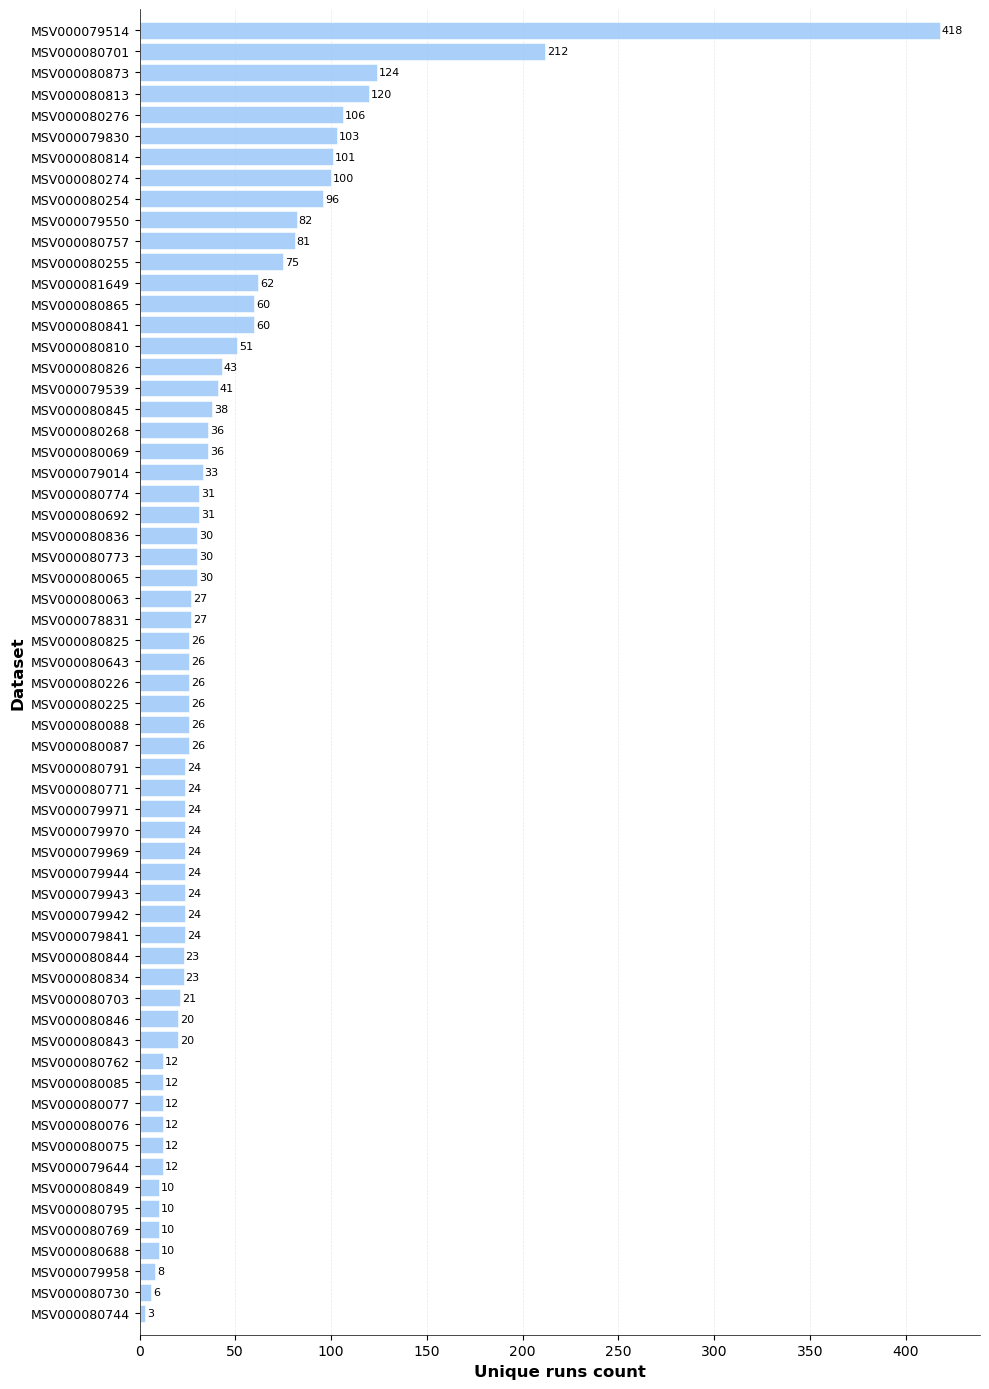

In [19]:
unique_filenames_dataset = df.groupby('dataset')['filename'].nunique()
plot_dataset_distributions(unique_filenames_dataset,'Unique runs count','Dataset')

## Peptide distributions

In [20]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [21]:
overlap_in_file = df.groupby(['modified_sequence','filename'])['filename'].count()

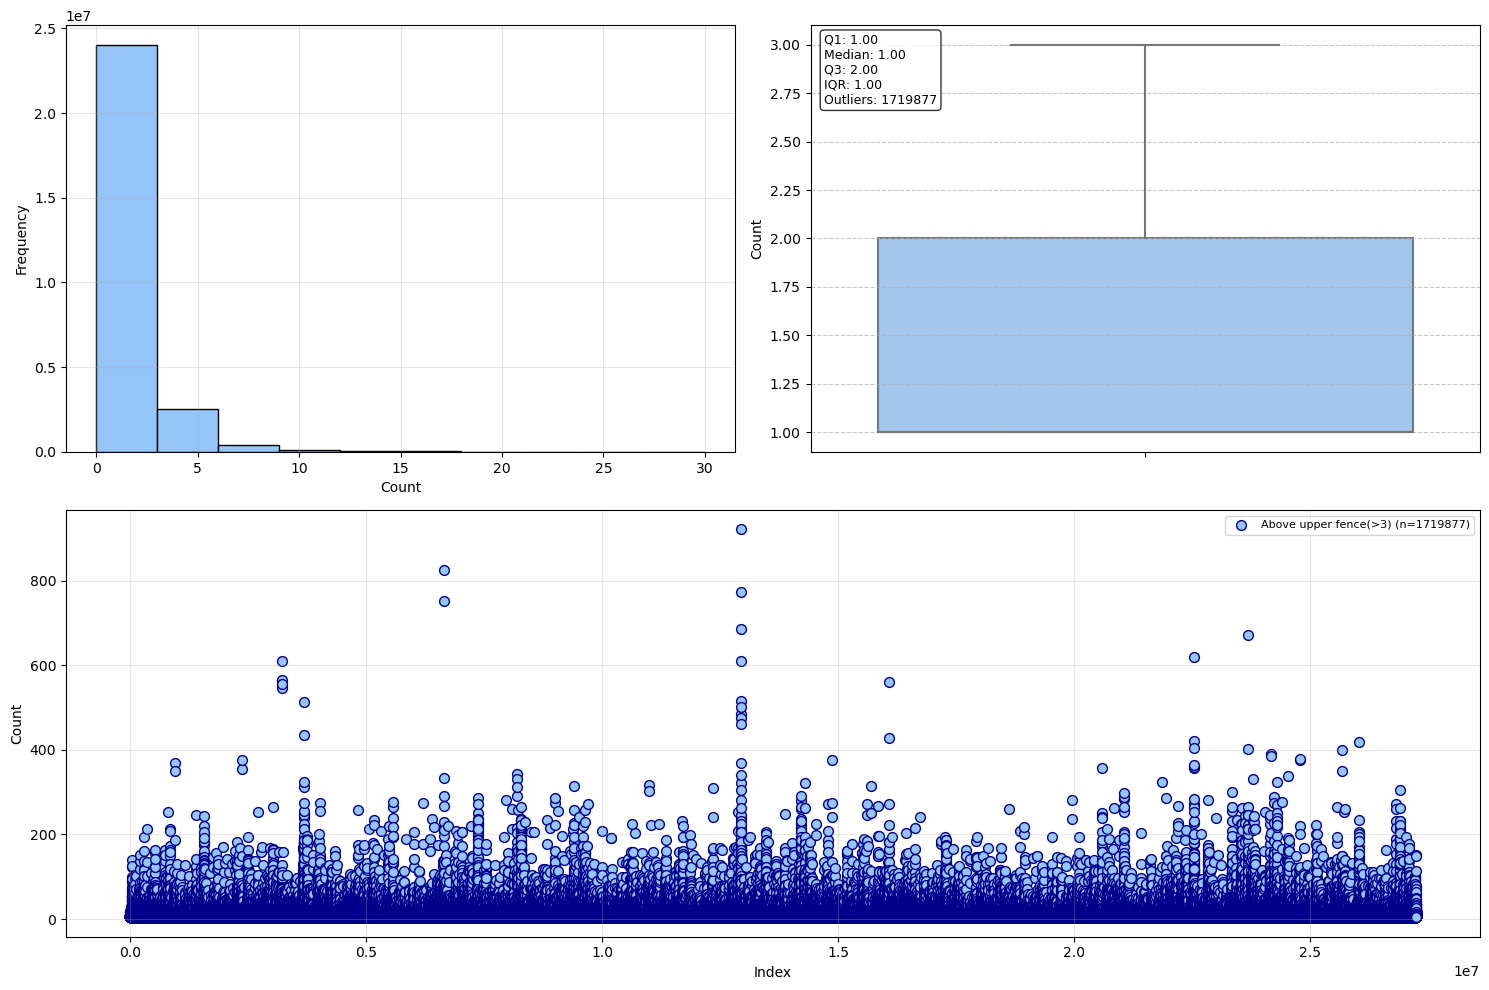

In [22]:
combined_plot(overlap_in_file, "Count",range=(0,30))

In [23]:
overlap_across_file = df.groupby('modified_sequence')['filename'].nunique()

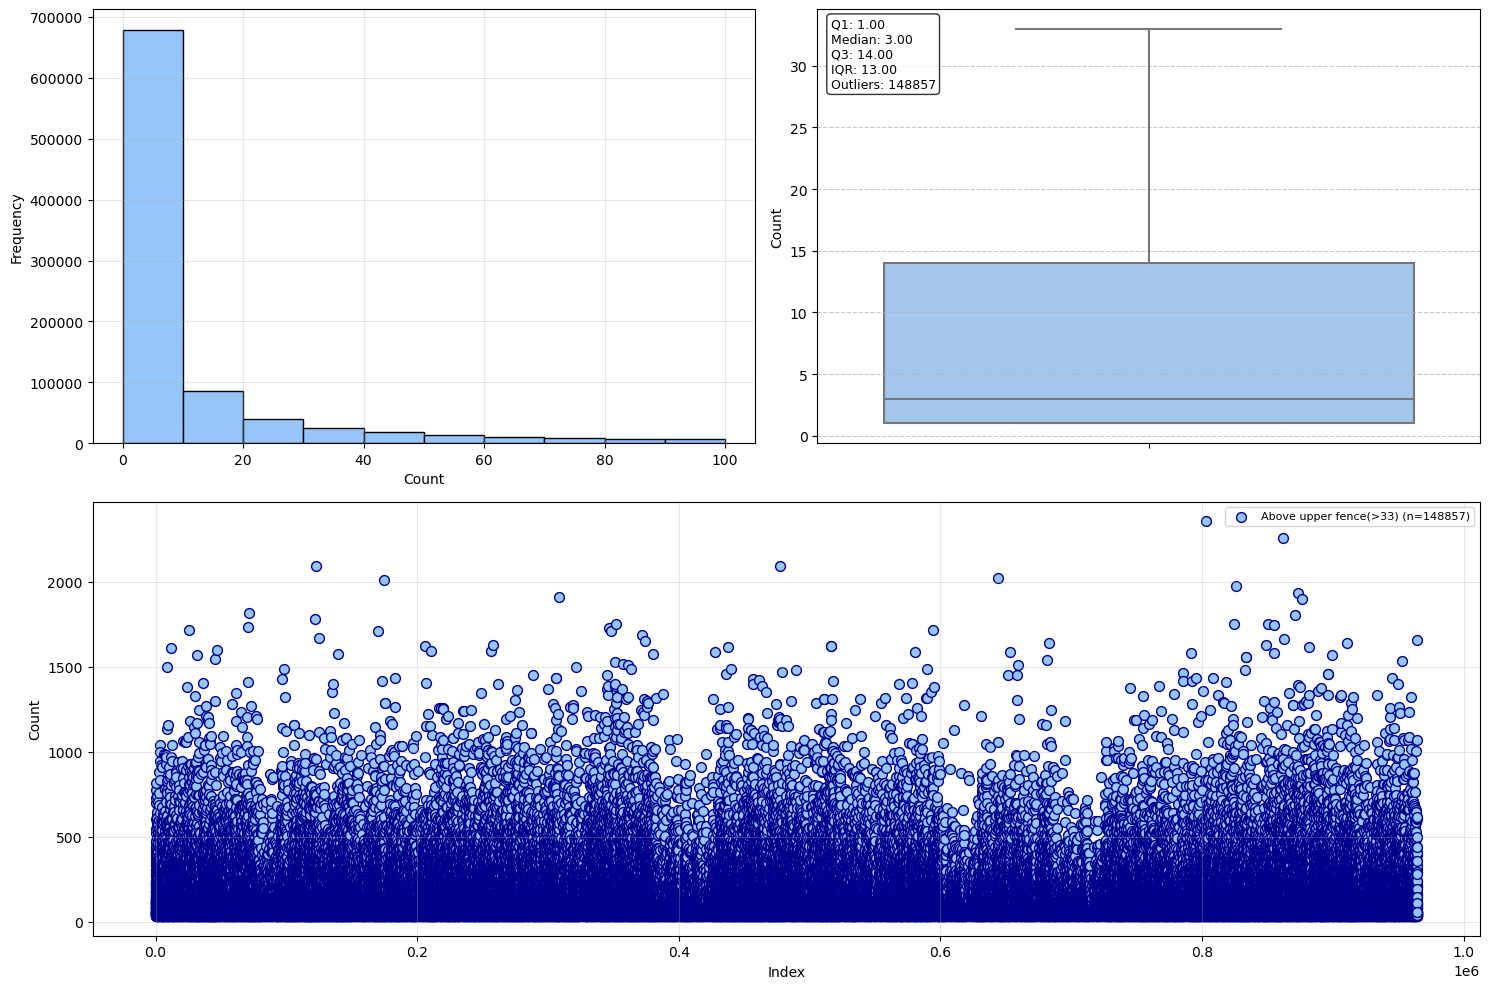

In [24]:
combined_plot(overlap_across_file, "Count",range=(0,100))

# Retention time analysis

In [25]:
def median_absolute_deviation(series, threshold=None):
    if threshold is not None and len(series) < threshold:
        return None
    return stats.median_abs_deviation(series.values)

## MAD comparison

In [26]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [27]:
mad_msrun = df.groupby(['modified_sequence', 'filename'])['label'].progress_apply(
    lambda x: median_absolute_deviation(x, 2)
).dropna()

  0%|          | 0/27236456 [00:00<?, ?it/s]

In [28]:
mad_dataset = df.groupby(['modified_sequence', 'dataset'])['label'].progress_apply(
    lambda x: median_absolute_deviation(x, 2)
).dropna()

  0%|          | 0/5237543 [00:00<?, ?it/s]

In [29]:
mad_all = df.groupby(['modified_sequence'])['label'].progress_apply(
    lambda x: median_absolute_deviation(x, 2)
).dropna()

  0%|          | 0/964395 [00:00<?, ?it/s]

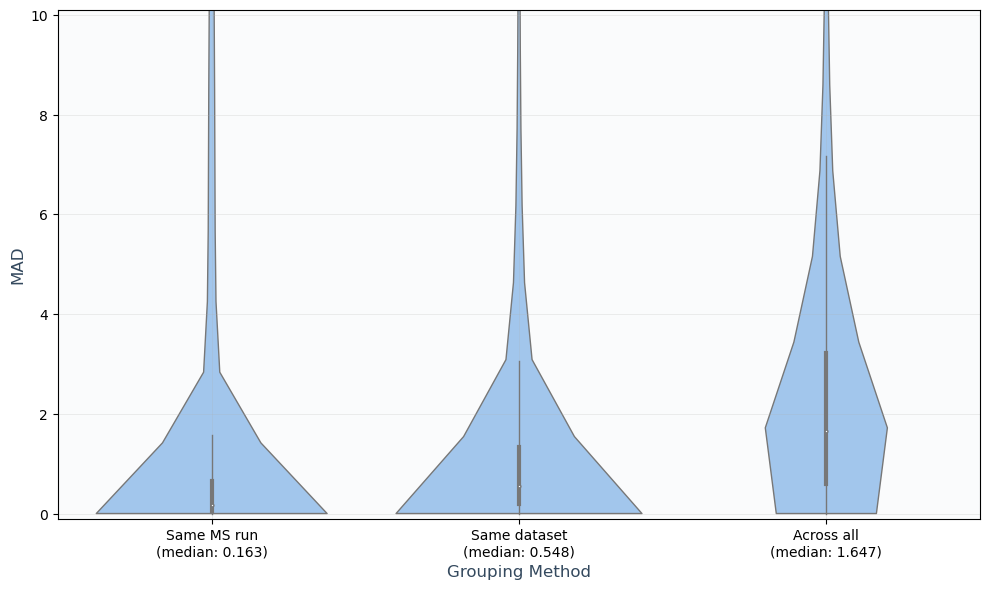

In [30]:
create_MAD_comparison_violinplot([mad_msrun,mad_dataset,mad_all],["Same MS run","Same dataset","Across all"],title="")

## MAD outliers

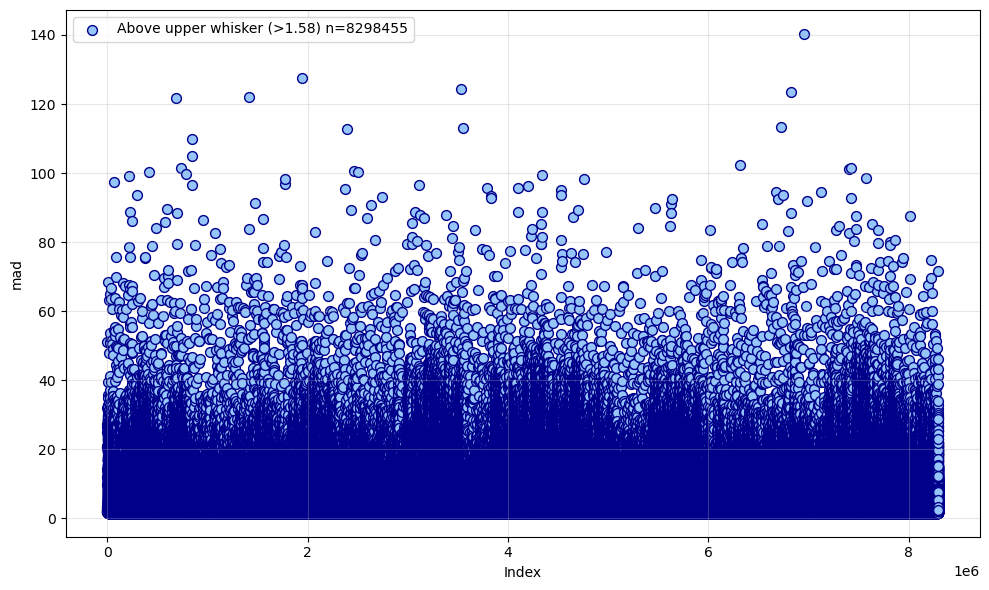

In [31]:
plot_scatter(mad_msrun,'mad')

## KDE plots

In [32]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [33]:
overlap_all = df.groupby('modified_sequence')['filename'].nunique()
overlap_msrun = df.groupby(['modified_sequence','filename'])['filename'].count()

In [34]:
interesting_peptides_across = overlap_all[(overlap_all > 10) & (overlap_all < 30)].index
# Filter rows where the value is > 5
filtered = overlap_msrun[overlap_msrun > 5]

sequence_counts = filtered.groupby('modified_sequence').count()
interesting_peptides_inside = sequence_counts[sequence_counts > 5].index
interesting_peptides = interesting_peptides_across.intersection(interesting_peptides_inside)[:10]

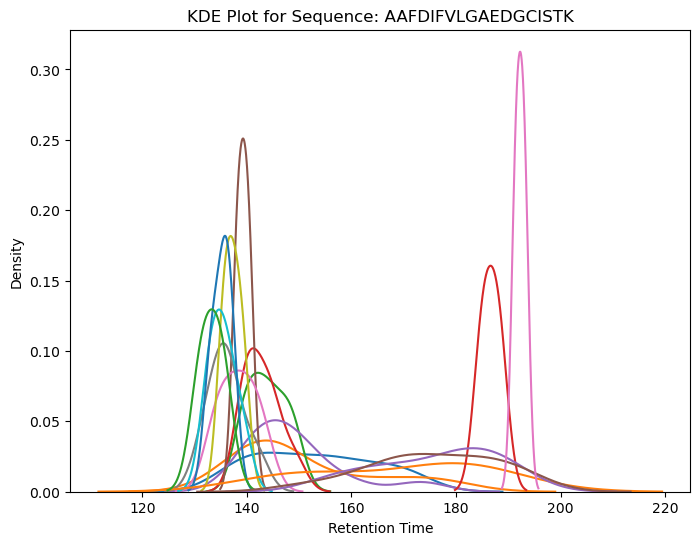

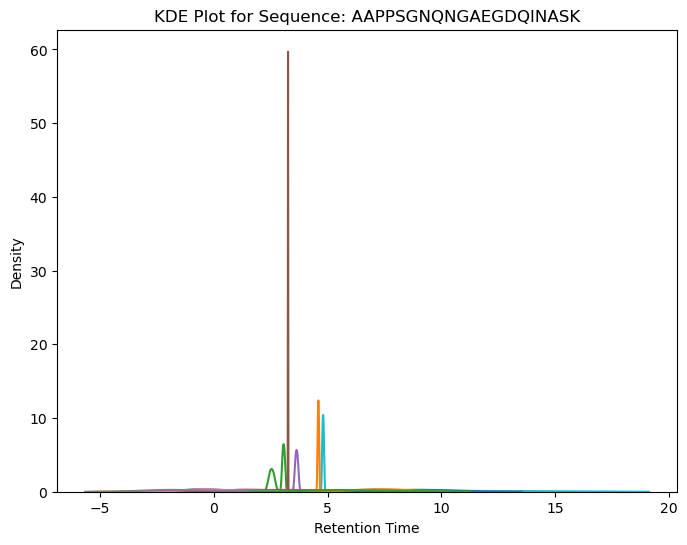

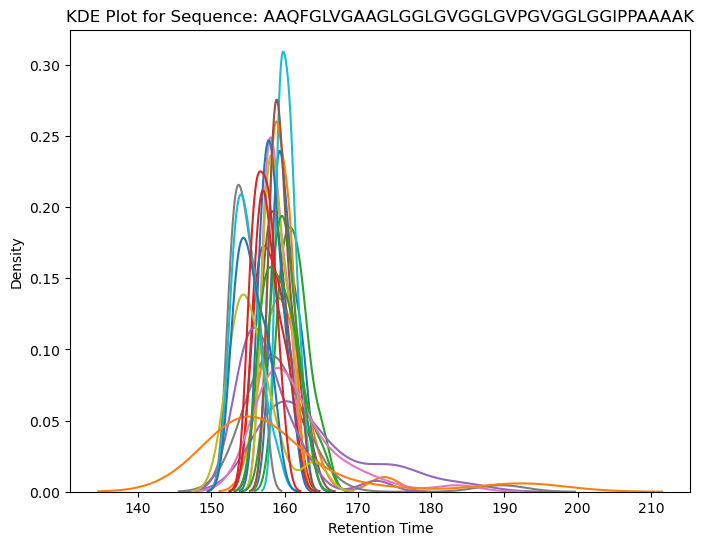

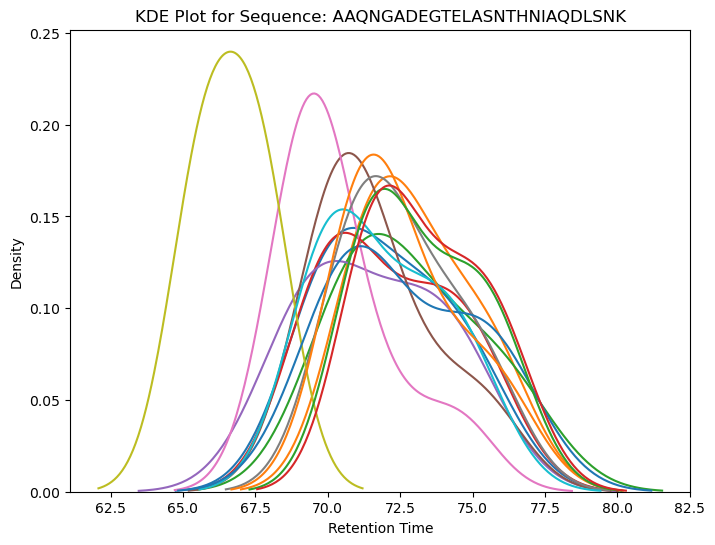

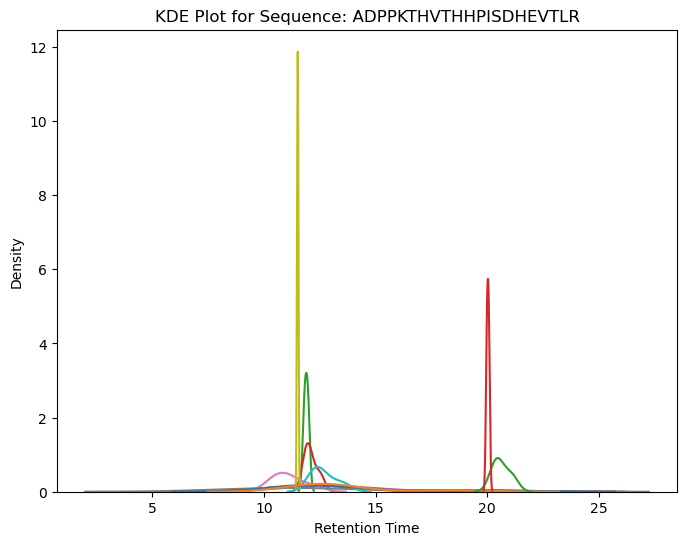

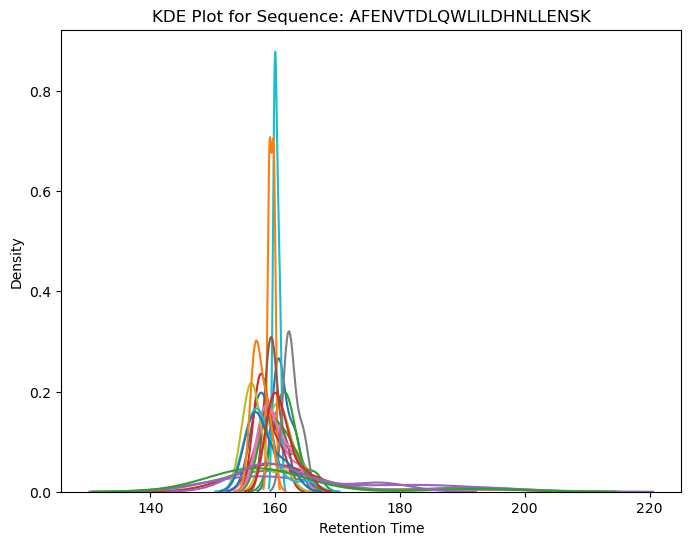

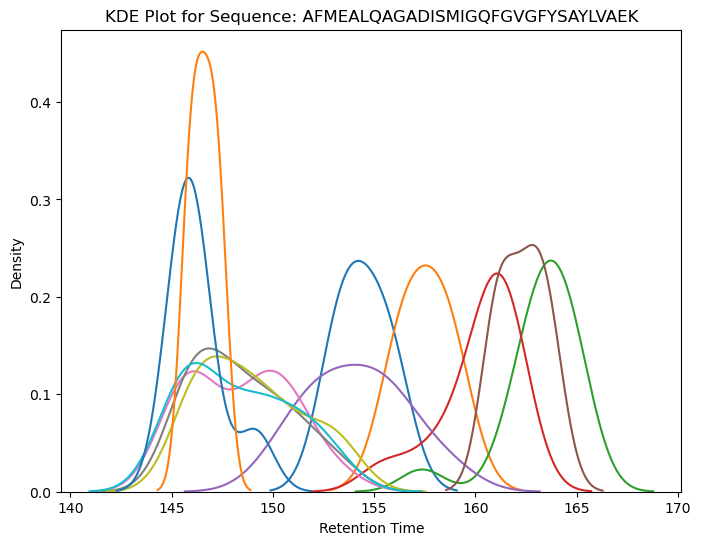

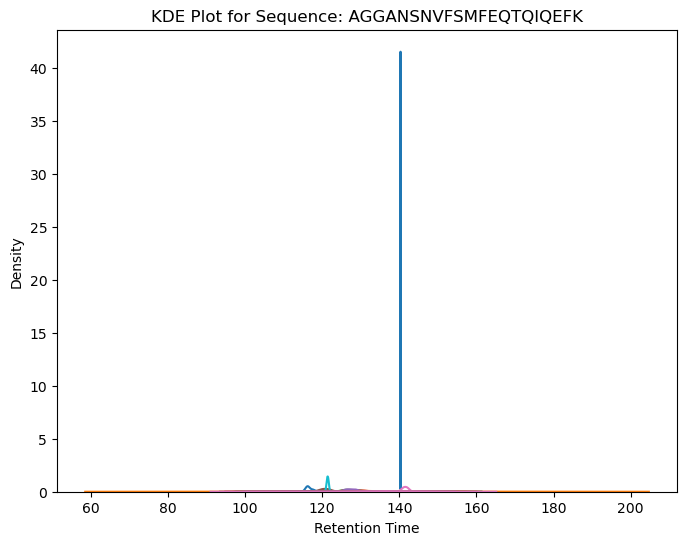

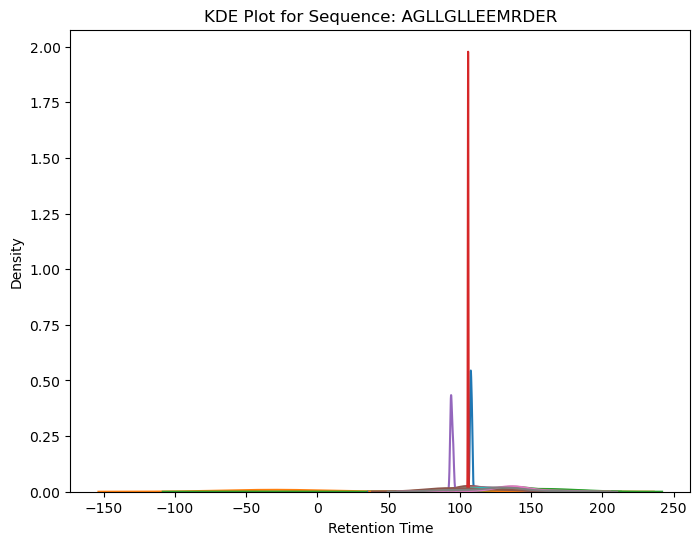

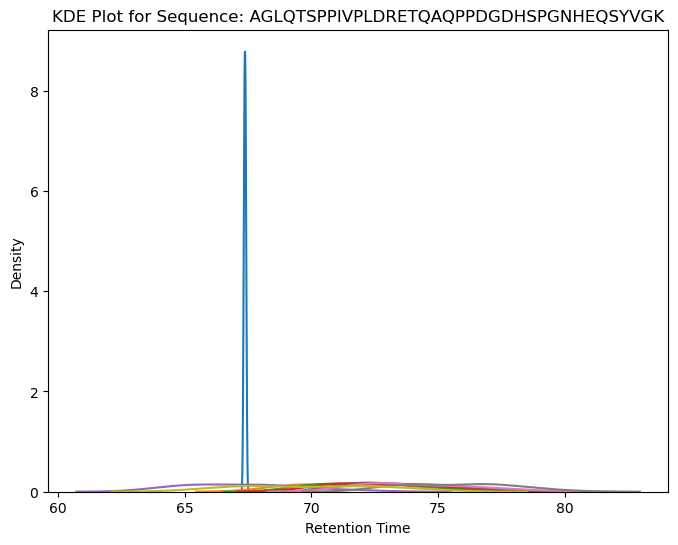

In [35]:
df_sequence = df[df['modified_sequence'].isin(interesting_peptides)]
plot_kde_grouped(df_sequence,2,legend=False)